# Confidence calculations

In [34]:
"""
Script to solve the first part of the data mining course project. Analysing data
"""

from __future__ import print_function
print('Importing packages... ',end='')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from collections import Counter
import warnings
print('done')

# Pandas setup
pd.options.display.float_format = '{:.4f}'.format
pd.options.display.max_rows = 10

# Load some data
print('Loading data...',end='')
data = pd.read_csv('datasets/Project_Dataset.csv')
print('done')

# Figure out what datatype each column contain
"""
float_cols = [key for key,val in data.dtypes.items() if val == 'float64']
not_float_cols = [key for key in float_cols if \
    sum(data[key].apply(lambda i:i.is_integer())) == sum(~data[key].isna())]
float_cols = [col for col in float_cols if col not in not_float_cols]
int_cols = [key for key,val in data.dtypes.items() if val == 'int64']
time_cols = [col for col in data.columns if col not in int_cols+float_cols+not_float_cols]
"""
"To save time we set these manually"
float_cols = ['Operation_TIME', 'Operation_DISTANCE', 'Gear_Level_Auto_Time', 'Gear_Level_Man_Time', 'Total_Distance', 'Brake_Time', 'Cruise_Time', 'Drive_Distance', 'Drive_Fuel', 'Drive_Time', 'Idle_Fuel', 'Coasting_Time', 'Econ_Time', 'Idle_Time', 'Key_On_Time', 'Pedal_Time', 'measure35', 'measure36', 'measure37', 'measure38', 'measure39', 'measure41', 'measure42', 'measure43', 'measure44', 'measure45', 'measure46', 'measure47', 'measure48', 'measure49', 'Measure_G-1_Time', 'State_Of_Health_Battery', 'Diesel_Mode_Total_Fuel', 'measure50', 'measure51', 'Measure_3', 'Electric_Mode_Time', 'Hybrid_Mode_Time', 'Charge_Mode_Time', 'Diesel_Mode_Time', 'Total_Time', 'Electric_Mode_Distance', 'Hybrid_Mode_Distance', 'Diesel_Mode_Distance', 'Total_Distance__ElectricHybridDiesel']
not_float_cols = ['Charge_mode_DISTANCE', 'measure40', 'Battery_Generation', 'Fleet_ID', 'Country', 'Measure_2', 'Active_Charge', 'Mounted_Battery_Generation', 'Measure_1', 'Measure_R_D', 'Engine_Type', 'Geo_Area', 'City', 'Cluster', 'Battery_Supplier']
int_cols = ['Sample_ID', 'Vehicle_ID', 'Sender', 'Battery_Version', 'Vehicle_MRK_TYPE', 'EMISSION_LEVEL', 'CURRENT_YEARLY_MILEAGE', 'Measure_ROw', 'Is_Bttery_Changed', 'IS_PATTERN_AVAILABLE', 'IS_FLEET_TOF_MONITORED', 'IS_CHECKED_IN_VDA', 'IS_Battery_Supplier_Type2_FAULTY', 'IS_VIP_FLEET']
time_cols = ['SEND_TIME', 'Battery_Replacement_date']
assert(len(float_cols+not_float_cols+int_cols+time_cols) == len(data.columns))
"Convert dates to timestamps"
date2time = lambda d:datetime.datetime.fromisoformat(d).timestamp()
for time_col in time_cols:
    data[time_col].update(data[time_col].dropna().apply(date2time))
">>>len(data[data['Country'].isna()]) -> 1"
"Looks like only one sample is missing Country id so lets drop that"
data.dropna(subset=['Country'],inplace=True)

# Count fill percentage
"We know data is sparse so lets put a number on it"
def is_confident(data,label:str=None,threshold:int=0.999):
    if label:
        df = data[~data[label].isna()]
    else:
        df = data
    return [(val/len(df),key)for key,val in df.count().items() \
     if val/len(df) > threshold]

def print_data_fill(amount:int):
    data_fill = sorted(is_confident(data,threshold=0),reverse=True)
    print(*data_fill[:amount],sep='\n')

# Extract info from NaN values
"""Use confidence to infer 1 way relationships between data. If the presence
of one data implies the presence of another it is worth looking into"""

def confidence_relations(data):
    "Generates a pair of dict mapping high confidence of data presence back and forth"
    "Remove info that is always true to avoid cluttering the info"
    redundant_info = is_confident(data)
    redundant_info = [val for i,val in redundant_info]
    conf_data = data.drop(columns=redundant_info)
    "Find the confidence"
    high_conf = {key:is_confident(conf_data,key) for key in conf_data.columns}
    high_conf = {key:[v for i,v in vals] for key,vals in high_conf.items()} #discard numbers
    "Reverse the dict"
    reverse_conf = {key:[] for key in high_conf}
    for key, val in high_conf.items():
        for v in val:
            reverse_conf[v].append(key)
    return high_conf, reverse_conf

def print_confidence_count(amount:int):
    high_conf, reverse_conf = confidence_relations(data)
    confidence_count = [(len(val),key) for key,val in reverse_conf.items()]
    confidence_count = sorted(confidence_count,reverse=True)
    print(*confidence_count[:amount],sep='\n')

# Look for an interesting class data
"Measure number of classes in class columns"
def print_number_of_classes():
    number_of_classes = data[int_cols+not_float_cols].apply(lambda c:len(c.unique()))
    number_of_classes = sorted(number_of_classes.items(),key=lambda x:x[1],reverse=True)
    print(*[f'{value}\t{key}' for key,value in number_of_classes],sep='\n')
    
    
"Measure class imbalance"
class_counter = data[int_cols+not_float_cols].fillna(-1.0).apply(lambda x:Counter(x))
class_counter.index=int_cols+not_float_cols
def print_class_counter_to_number_of_classes():
    "This should return the same as number of classes. Used for testing only"
    temp = sorted(class_counter.items(),key=lambda x:len(x[1]),reverse=True)
    temp = [f'{len(val)}\t{key}' for key,val in temp]
    print(*temp,sep='\n')

def print_class_std():
    class_std = [(np.std([*val.values()]),key) for key,val in class_counter.items()]
    class_std = sorted(class_std,reverse=True)
    class_std = [f'{val:.10}\t{name}' for val,name in class_std]
    print(*class_std,sep='\n')
    "for reference >>> np.std([int(.9*l),int(.1*l)]) -> 344766.0"
    
# Visualize data
def do_tsne(perp:int,cols:list,points:int=500):
    from sklearn.manifold import TSNE
    sne_data = TSNE(perplexity=perp).fit_transform(data[cols].dropna().iloc[:points])
    plt.scatter(*sne_data.T)
    plt.show()
"""
do_tsne(25,float_cols)
do_tsne(25,int_cols)
do_tsne(40,not_float_cols)
do_tsne(40,time_cols)
do_tsne(40,float_cols+time_cols+int_cols+not_float_cols)
do_tsne(40,float_cols+time_cols)

"""
# Feature selection with Variance Threshold
"""
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold=(.9 * (1 - .9)))
vt.fit(data)
print([col for col,support in zip(data.columns,vt.get_support()) if ~support])

When compared with print_class_std it removes 2 extra featues.
class_counter['Measure_2'] shows that Measure_2 has a 90% class imbalance IF
one ignores the NaN values. We cannot conclude there is no information in NaN.
Setting a "magic number" to NaN suggests values from the top down of print_class_std.
Pros:
 -Simple and clean
Cons:
 -Does not provide new information
 -Drops NaN without warning
 -Disregards the target label when selecting features
Conclusion: Variance Threshold provides missleading or redunant information.
"""

# Feature selection with SelectKBest mutual_info_regression
"""
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
SKB = SelectKBest(mutual_info_regression, k=71)
df = data.iloc[:10000]
SKB.fit(df.loc[:,df.columns != 'measure41'].fillna(-1),df['measure41'].fillna(-1))
print([col for col,support in zip(data.columns,SKB.get_support()) if ~support])
['Gear_Level_Man_Time', 'measure40', 'Is_Bttery_Changed', 'IS_CHECKED_IN_VDA']

Pros:
 -Backed up by: L. F. Kozachenko, N. N. Leonenko, “Sample Estimate of the Entropy of a Random Vector”, Probl. Peredachi Inf., 23:2 (1987), 9-16
Cons:
 -Had to use fillna to get an output. A better solution to NaN is required.
 -Memory complexity is high.
Conclusion: With adaptation it could provide useful inforamtion.
"""

# Feature selection with SelectKBest f_regression
"""
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
SKB = SelectKBest(f_regression, k=71)
df = data.iloc[:]
SKB.fit(df.loc[:,df.columns != 'measure41'].fillna(-1),df['measure41'].fillna(-1))
print([col for col,support in zip(data.columns,SKB.get_support()) if ~support])

Pros:
 -Good time and memory complexity
Cons:
 -Correlation assumes linear relationship
 -Need a solution to NaN values
Conclusion: A good first draft for selection but not conclusive
"""

# Feature selection with Recursive feature elimination with cross validation
"""
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
df = data.iloc[:10000]
X = df.loc[:,df.columns != 'measure41'].fillna(-1)
y = df['measure41'].fillna(-1)
rfecv = RFECV(SVR(kernel="linear"), min_features_to_select=71, step=1, cv=5)
rfecv = rfecv.fit(X, y)
print([col for col,support in zip(data.columns,rfecv.get_support()) if ~support])

Pros:
 -Has reference: Guyon, I., Westoprint_class_counter_to_number_of_classesn, J., Barnhill, S., & Vapnik, V., “Gene selection for cancer classification using support vector machines”, Mach. Learn., 46(1-3), 389–422, 2002.
 -Can find optimal number of features (rfecv.n_features_)
 -Can chose estimator based on model
Cons:
 -Poor time complexity? (never finished execution) (and single threaded)
"""

# Feature selection with SelectFromModel and LogisticRegression
"""
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
df = data.iloc[:10000]
X = df.loc[:,df.columns != 'measure41'].fillna(-1)
y = df['measure41'].fillna(-1)
lr = LogisticRegression(C=0.1, penalty="l1", dual=False, max_iter=1000, solver='saga')
lr.fit(X, y)
sfm = SelectFromModel(lr, prefit=True)
print([col for col,support in zip(data.columns,sfm.get_support()) if ~support])
cons:
 -This shit is for classification
"""

# Feature selection with SelectFromModel and linear_model.Lasso



Importing packages... done
Loading data...done


'\nfrom sklearn.feature_selection import SelectFromModel\nfrom sklearn.linear_model import LogisticRegression\ndf = data.iloc[:10000]\nX = df.loc[:,df.columns != \'measure41\'].fillna(-1)\ny = df[\'measure41\'].fillna(-1)\nlr = LogisticRegression(C=0.1, penalty="l1", dual=False, max_iter=1000, solver=\'saga\')\nlr.fit(X, y)\nsfm = SelectFromModel(lr, prefit=True)\nprint([col for col,support in zip(data.columns,sfm.get_support()) if ~support])\ncons:\n -This shit is for classification\n'

In [6]:
print_number_of_classes()
print_class_counter_to_number_of_classes()
print_class_std()

777466	Sample_ID
4030	Vehicle_ID
4030	Measure_ROw
297	Fleet_ID
254	measure40
125	City
116	Measure_R_D
33	CURRENT_YEARLY_MILEAGE
27	Country
22	Measure_1
9	Vehicle_MRK_TYPE
9	Geo_Area
9	Cluster
7	Battery_Generation
7	Mounted_Battery_Generation
5	Battery_Version
5	Engine_Type
5	Battery_Supplier
4	Sender
3	Measure_2
3	Active_Charge
2	EMISSION_LEVEL
2	Is_Bttery_Changed
2	IS_PATTERN_AVAILABLE
2	IS_FLEET_TOF_MONITORED
2	IS_CHECKED_IN_VDA
2	IS_Battery_Supplier_Type2_FAULTY
2	IS_VIP_FLEET
2	Charge_mode_DISTANCE
777466	Sample_ID
4030	Vehicle_ID
4030	Measure_ROw
297	Fleet_ID
254	measure40
125	City
116	Measure_R_D
33	CURRENT_YEARLY_MILEAGE
27	Country
22	Measure_1
9	Vehicle_MRK_TYPE
9	Geo_Area
9	Cluster
7	Battery_Generation
7	Mounted_Battery_Generation
5	Battery_Version
5	Engine_Type
5	Battery_Supplier
4	Sender
3	Measure_2
3	Active_Charge
2	EMISSION_LEVEL
2	Is_Bttery_Changed
2	IS_PATTERN_AVAILABLE
2	IS_FLEET_TOF_MONITORED
2	IS_CHECKED_IN_VDA
2	IS_Battery_Supplier_Type2_FAULTY
2	IS_VIP_FLEET
2	Charg

In [16]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
df = data.iloc[:10000]
X = df.loc[:,df.columns != 'measure41'].fillna(0)
y = df['measure41'].fillna(0)

AttributeError: 'RobustScaler' object has no attribute 'fit_transfrom'

In [37]:
import seaborn as sns
#sns.barplot(data=temp_df, orient="h", medianprops={'color':'blue'})
number_of_classes = data[int_cols+not_float_cols].apply(lambda c:len(c.unique()))
class_std = [(np.std([*val.values()]),key) for key,val in class_counter.items()]


list

In [39]:
number_of_classes.head()

Sample_ID           777466
Vehicle_ID            4030
Sender                   4
Battery_Version          5
Vehicle_MRK_TYPE         9
dtype: int64

In [49]:
#class_counter
#type(class_counter)
#class_counter.apply(lambda key,val: np.std([*val.values()]))
number_and_std = [(cval,sval,label) for cval,(sval,label) in zip(number_of_classes.values,class_std)]
number_and_std

[(777466, 0.32740964138449535, 'Sample_ID'),
 (4030, 395.00339468917326, 'Vehicle_ID'),
 (4, 255178.39026784283, 'Sender'),
 (5, 304129.35066974384, 'Battery_Version'),
 (9, 94092.07300180913, 'Vehicle_MRK_TYPE'),
 (2, 146088.5, 'EMISSION_LEVEL'),
 (33, 52218.279783661375, 'CURRENT_YEARLY_MILEAGE'),
 (4030, 395.00339468917326, 'Measure_ROw'),
 (2, 262748.5, 'Is_Bttery_Changed'),
 (2, 390377.5, 'IS_PATTERN_AVAILABLE'),
 (2, 258547.5, 'IS_FLEET_TOF_MONITORED'),
 (2, 134010.5, 'IS_CHECKED_IN_VDA'),
 (2, 428463.5, 'IS_Battery_Supplier_Type2_FAULTY'),
 (2, 394235.5, 'IS_VIP_FLEET'),
 (2, 192880.5, 'Charge_mode_DISTANCE'),
 (254, 45909.919555090884, 'measure40'),
 (7, 174784.7454823988, 'Battery_Generation'),
 (297, 9239.26143023052, 'Fleet_ID'),
 (27, 62043.8751615478, 'Country'),
 (3, 224628.95089606475, 'Measure_2'),
 (3, 385534.6329769437, 'Active_Charge'),
 (7, 177645.8976075032, 'Mounted_Battery_Generation'),
 (22, 75017.60687057968, 'Measure_1'),
 (116, 25584.303029133873, 'Measure_R_

In [103]:
test=pd.DataFrame(number_and_std,columns=['numberOfClasses','std','label'])
test.index=test['label']
del test['label']



(0.0, 5000.0)

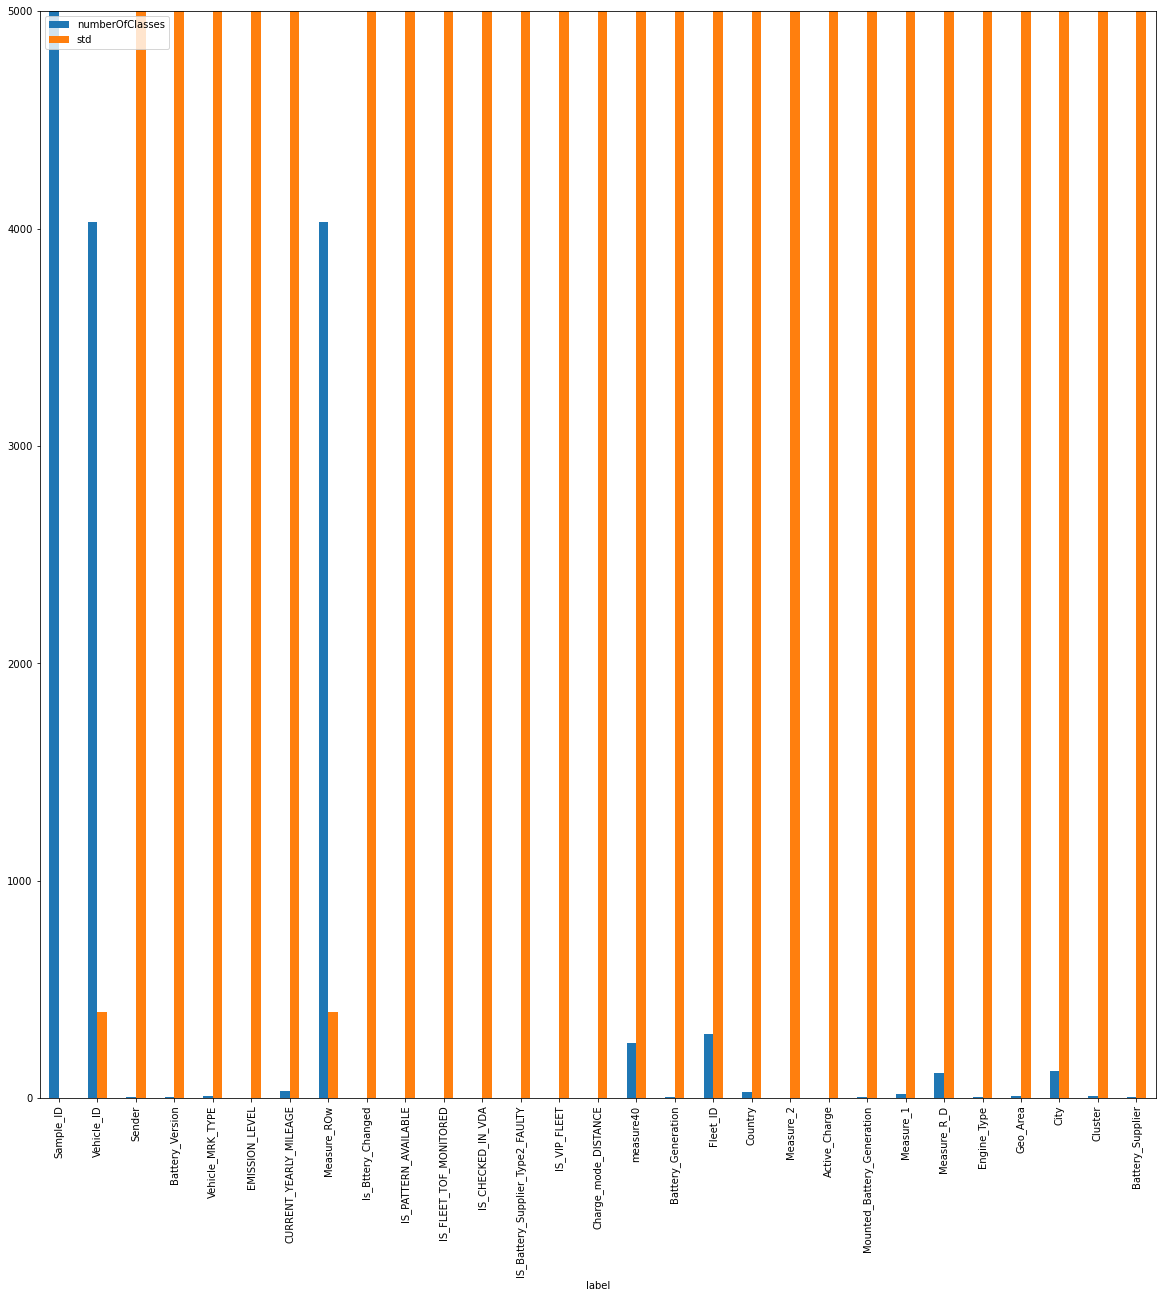

In [113]:
test
ax1 = test.plot(kind='bar',figsize=(20, 20))
ax1.set_ylim(0,5000)


In [83]:
pd.DataFrame({
    'Factor': ['Growth', 'Value'],
    'Weight': [0.10, 0.20],
    'Variance': [0.15, 0.35]
}).head()

,Factor,Weight,Variance
0,Growth,0.1000,0.1500
1,Value,0.2000,0.3500
